In [2]:
!pip install optuna-integration[wandb]

Defaulting to user installation because normal site-packages is not writeable
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 45.0 MB/s eta 0:00:00a 0:00:01m
Using cached click-8.2.1-py3-none-any.whl (102 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# HiTwinFormer

workflow:

create conda environment with environment.yml file using: conda env create -f environment.yml

create mlhic data with generate_mlhic.py script

run main-v3_with_supcon.py to generate model. I recommend doing triplet loss with 0 augmentations for now.

run make_feature_maps.py to make feature maps

Now, you are ready to look at the results of the model with visualise_changes.ipynb.

In [3]:
import hicstraw
import torch
#import torchvision.transforms as T
import numpy as np
from HiSiNet.HiCDatasetClass import HiCDatasetDec
import matplotlib.pyplot as plt
from PIL import Image
import random


In [1]:
import os
import json
from HiSiNet.HiCDatasetClass import HiCDatasetDec, reference_genomes

# Get list of chromosomes from the reference genome
reference_genome_index = "mm9" # Options are hg19, hg38, mm9, mm10, FlyBasev6.07
_, chromsizes = reference_genomes[reference_genome_index]
all_chroms = list(chromsizes.keys())  # ['chr1','chr2','chr3',…, 'chrX','chrY','1']

# Define chrom splits
default_exclude = ['chrY','chrX', 'Y', 'X', 'chrM', 'M']
test_chroms = ['2', 'chr2']
val_chroms = ['18', 'chr18']
resolution = 10000
tile_size = 224

exclude_for_train = default_exclude + [c for c in test_chroms + val_chroms]
exclude_for_test = default_exclude + [c for c in all_chroms if c not in test_chroms]
exclude_for_val = default_exclude + [c for c in all_chroms if c not in val_chroms]

# Define your data (remember they all need to have a consistent order)
replicate_ids = ["R1", "R2", "R3", "R4"] # define which replicate
condition_ids = [0, 0, 1, 1]  # KO=1, control=0
input_data_files = [
    "/home/tt920/mnt/network/lymphdev/Tim/GSM4386021_hic_0h_rep1.hic", 
    "/home/tt920/mnt/network/lymphdev/Tim/GSM4386021_hic_0h_rep2.hic",
    "/home/tt920/mnt/network/lymphdev/Tim/GSM4386024_hic_48h_rep1.hic",
    "/home/tt920/mnt/network/lymphdev/Tim/GSM4386024_hic_48h_rep2.hic"
]
output_data_folder = "/home/tt920/mnt/scratch/tt920/mlhic/"
json_file_name = f"ES_CTCF_{tile_size}.json" # where the input paths for the ML model are saved

# Prepare output structure
json_dict = {
    "control": {
        "reference": reference_genome_index,
        "training": [],
        "validation": [],
        "test": []
    },
    "KO": {
        "reference": reference_genome_index,
        "training": [],
        "validation": [],
        "test": []
    }
}
print(all_chroms)
print(exclude_for_train)
print(exclude_for_test)
print(exclude_for_val)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
['chrY', 'chrX', 'Y', 'X', 'chrM', 'M', '2', 'chr2', '18', 'chr18']
['chrY', 'chrX', 'Y', 'X', 'chrM', 'M', 'chr1', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', '1', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
['chrY', 'chrX', 'Y', 'X', 'chrM', 'M', 'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr19', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '19']


In [ ]:
for i in range(len(input_data_files)):
    input_file = input_data_files[i]
    replicate = replicate_ids[i]
    class_id = condition_ids[i]
    
    # Construct base name
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    
    # Prepare base arguments
    base_args = ([input_file, replicate, 'KR', 'BP', class_id], resolution, tile_size * resolution)

    all_out = os.path.join(output_data_folder, f"all_{base_name}_chr.mlhic")
    all_ds = HiCDatasetDec(*base_args, exclude_chroms=default_exclude)
    all_ds.save(all_out)
    # Save train
    train_out = os.path.join(output_data_folder, f"train_{base_name}.mlhic")
    train = HiCDatasetDec(*base_args, exclude_chroms=exclude_for_train)
    train.save(train_out)

    # Save test
    test_out = os.path.join(output_data_folder, f"test_{base_name}_chr{test_chroms[0]}.mlhic")
    test = HiCDatasetDec(*base_args, exclude_chroms=exclude_for_test)
    test.save(test_out)

    # Save validation
    val_out = os.path.join(output_data_folder, f"val_{base_name}_chr{val_chroms[0]}.mlhic")
    val = HiCDatasetDec(*base_args, exclude_chroms=exclude_for_val)
    val.save(val_out)

    # Add to json dict
    key = "KO" if class_id == 1 else "control" # This is where we use
    json_dict[key]["training"].append(train_out)
    json_dict[key]["validation"].append(val_out)
    json_dict[key]["test"].append(test_out)

# Save json
with open(json_file_name, "w") as f:
    json.dump(json_dict, f, indent=2)



In [2]:

replicate_id = 'R1' #replicate identifier can be anything  
class_id = 1 #class identifier must be int 
data = HiCDatasetDec(["/mnt/c/Users/timot/Downloads/CD69negDPPaxip1KOR1.hic", replicate_id , 'KR', 'BP', class_id],10000,2560000)
data.save('input2.mlhic')

In [4]:
print(exclude_for_train)

['2', 'chr2', '18', 'chr18']


In [1]:
from HiSiNet.HiCDatasetClass import HiCDatasetDec, GroupedHiCDataset, SiameseHiCDataset, HiCDataset
from HiSiNet.reference_dictionaries import reference_genomes

In [5]:

replicate_id = 'R1' #replicate identifier can be anything  
class_id = 1 #class identifier must be int 
data9 = HiCDatasetDec(["data/CD69negDPPaxip1KOR1.hic", replicate_id , 'KR', 'BP', 1],10000,2240000, exclude_chroms=exclude_for_train)
data9.save('input9.mlhic')

In [10]:
replicate_id = 'R2' #replicate identifier can be anything  
class_id = 1 #class identifier must be int 
data1 = HiCDatasetDec(["data/CD69negDPPaxip1KOR2.hic", replicate_id , 'KR', 'BP', 1],10000,2240000, exclude_chroms=exclude_for_train)
data1.save('input2.mlhic')

In [11]:
replicate_id = 'R3' #replicate identifier can be anything  
class_id = 0 #class identifier must be int 
data2 = HiCDatasetDec(["data/CD69negDPWTR3.hic", replicate_id , 'KR', 'BP', 0],10000,2240000, exclude_chroms=exclude_for_train)
data2.save('input3.mlhic')

In [20]:
replicate_id = 'R4' #replicate identifier can be anything  
class_id = 0 #class identifier must be int 
test = HiCDatasetDec(["data/CD69negDPWTR4.hic", replicate_id , 'KR', 'BP', 0],10000,2240000, exclude_chroms=exclude_for_train)
data3.save('input4.mlhic')

In [2]:
data = HiCDatasetDec.load("input1.mlhic")
data1 = HiCDatasetDec.load("input2.mlhic")
data2 = HiCDatasetDec.load("input3.mlhic")
data3 = HiCDatasetDec.load("input4.mlhic")


In [ ]:
data1 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386021_hic_0h_rep1_chr.mlhic")
data2 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386022_hic_0h_rep2_chr.mlhic")

data3= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386024_hic_48h_rep1_chr.mlhic") 
data4= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386025_hic_48h_rep2_chr.mlhic")


In [2]:
data1 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386026_hic_d4_ctl_rep1_chr.mlhic")
data2 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386027_hic_d4_ctl_rep2_chr.mlhic")
data3= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386028_hic_d4_aux_rep1_chr.mlhic") 
data4= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386029_hic_d4_aux_rep2_chr.mlhic")


In [13]:
data1 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/train_GSM4386026_hic_d4_ctl_rep1.mlhic")
data2 = HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/train_GSM4386027_hic_d4_ctl_rep2.mlhic")
data3= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/train_GSM4386028_hic_d4_aux_rep1.mlhic") 
data4= HiCDatasetDec.load("/home/tt920/mnt/scratch/tt920/mlhic/train_GSM4386029_hic_d4_aux_rep2.mlhic")

In [14]:
loss_function="triplet"
is_triplet = (loss_function == "triplet")
train_dataset = SiameseHiCDataset([data1,data2, data3, data4], triplet=False, supcon=True, reference=reference_genomes["mm9"])

In [17]:
train_dataset.metadata

(frozendict.frozendict({'filename': '/home/tt920/mnt/network/lymphdev/Tim/GSM4386026_hic_d4_ctl_rep1.hic', 'replicate': 'R1', 'norm': 'KR', 'type_of_bin': 'BP', 'class_id': 0, 'chromosomes': OrderedDict({'1': (0, 681), '3': (681, 1228), '4': (1228, 1717), '5': (1717, 2210), '6': (2210, 2719), '7': (2719, 3139), '8': (3139, 3562), '9': (3562, 3989), '10': (3989, 4421), '11': (4421, 4839), '12': (4839, 5217), '13': (5217, 5525), '14': (5525, 5900), '15': (5900, 6253), '16': (6253, 6585), '17': (6585, 6907), '19': (6907, 7108), 'chr1': (0, 0), 'chr2': (0, 0), 'chr3': (0, 0), 'chr4': (0, 0), 'chr5': (0, 0), 'chr6': (0, 0), 'chr7': (0, 0), 'chr8': (0, 0), 'chr9': (0, 0), 'chr10': (0, 0), 'chr11': (0, 0), 'chr12': (0, 0), 'chr13': (0, 0), 'chr14': (0, 0), 'chr15': (0, 0), 'chr16': (0, 0), 'chr17': (0, 0), 'chr18': (0, 0), 'chr19': (0, 0), '2': (0, 0), '18': (0, 0)})}),
 frozendict.frozendict({'filename': '/home/tt920/mnt/network/lymphdev/Tim/GSM4386027_hic_d4_ctl_rep2.hic', 'replicate': 'R2'

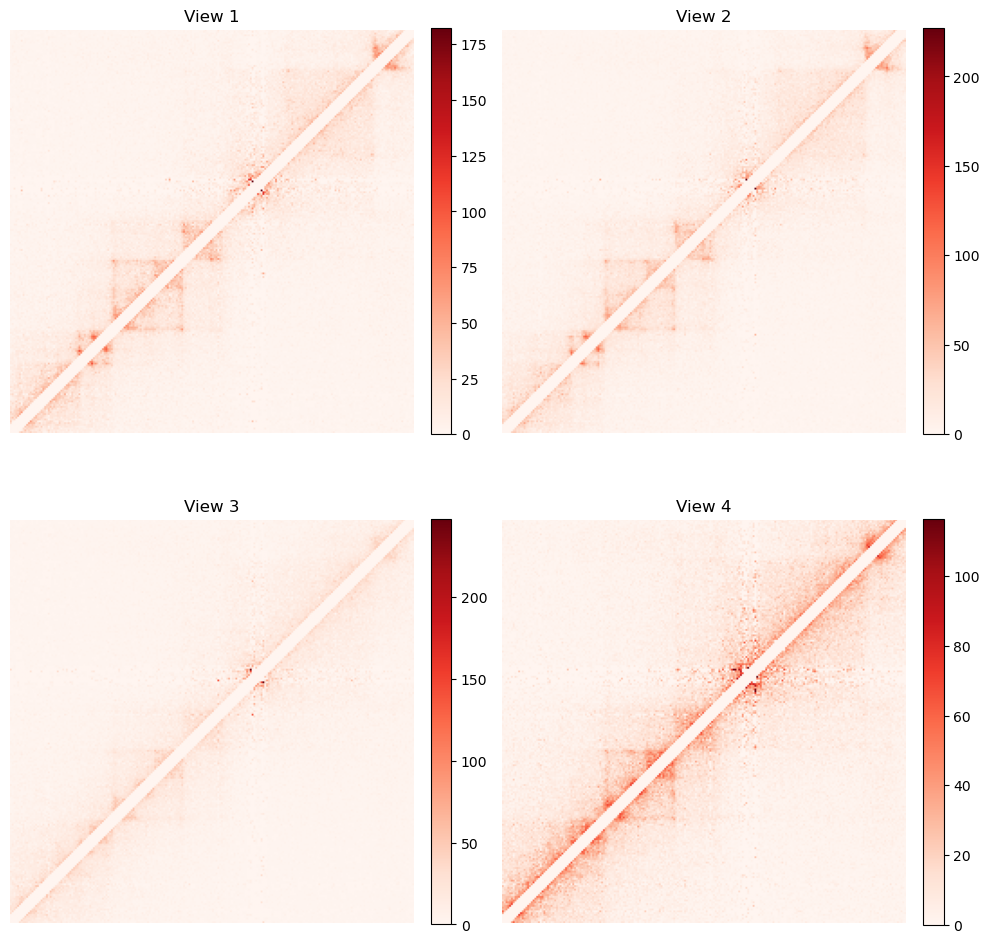

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load your tensor (shape: [4, 1, 224, 224])
tensor = train_dataset.data[100][0]  # shape: [4, 1, 224, 224]
tensor = tensor.squeeze(1)  # remove singleton channel dimension → [4, 224, 224]

# Create diagonal mask to remove ±6 diagonals
num_bins = 224
band_width = 4
mask = np.ones((num_bins, num_bins))
for k in range(-band_width, band_width + 1):
    mask += np.eye(num_bins, k=k) * -1
mask = np.clip(mask, 0, 1)
mask = torch.tensor(mask, dtype=tensor.dtype)

# Apply mask to all 4 slices
masked_tensor = tensor * mask

# Plot in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ['View 1', 'View 2', 'View 3', 'View 4']

for i in range(4):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(masked_tensor[i], cmap='Reds', origin='lower')
    ax.set_title(titles[i])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


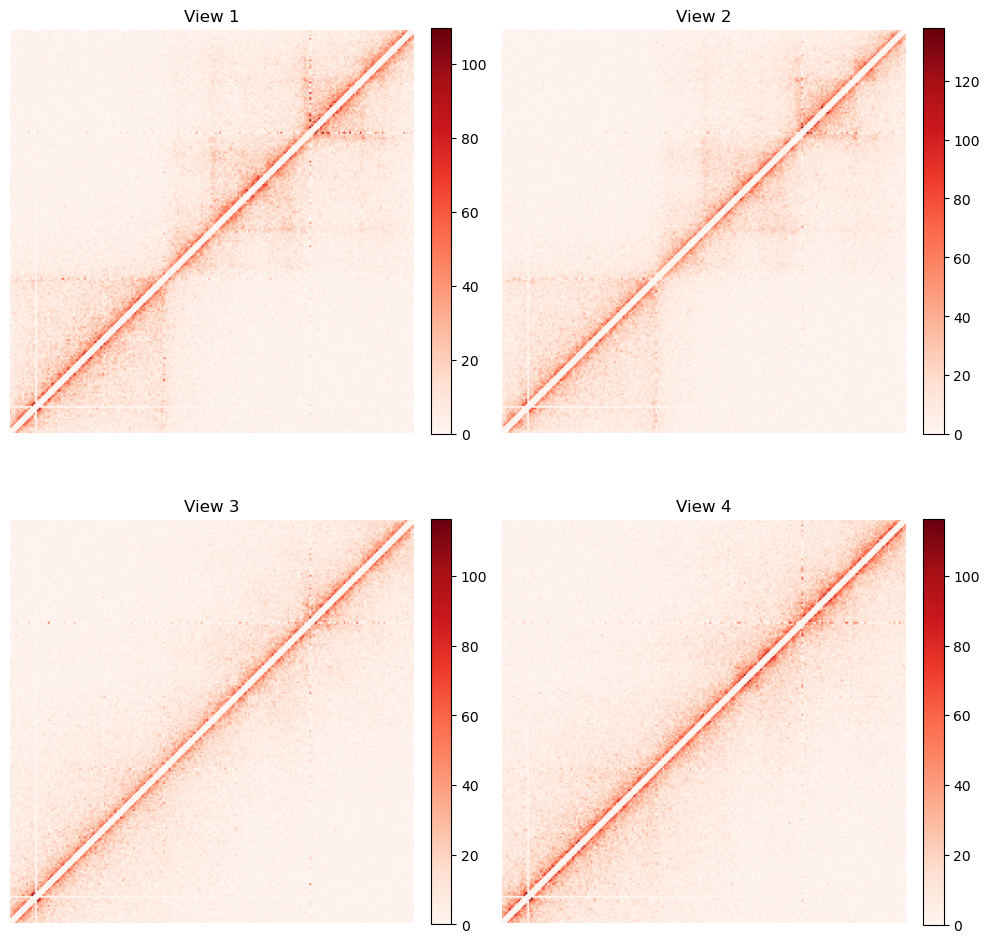

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load your tensor (shape: [4, 1, 224, 224])
tensor = train_dataset.data[200][0]  # shape: [4, 1, 224, 224]
tensor = tensor.squeeze(1)  # remove singleton channel dimension → [4, 224, 224]

# Create diagonal mask to remove ±6 diagonals
num_bins = 224
band_width = 2
mask = np.ones((num_bins, num_bins))
for k in range(-band_width, band_width + 1):
    mask += np.eye(num_bins, k=k) * -1
mask = np.clip(mask, 0, 1)
mask = torch.tensor(mask, dtype=tensor.dtype)

# Apply mask to all 4 slices
masked_tensor = tensor * mask

# Plot in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ['View 1', 'View 2', 'View 3', 'View 4']

for i in range(4):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(masked_tensor[i], cmap='Reds', origin='lower')
    ax.set_title(titles[i])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


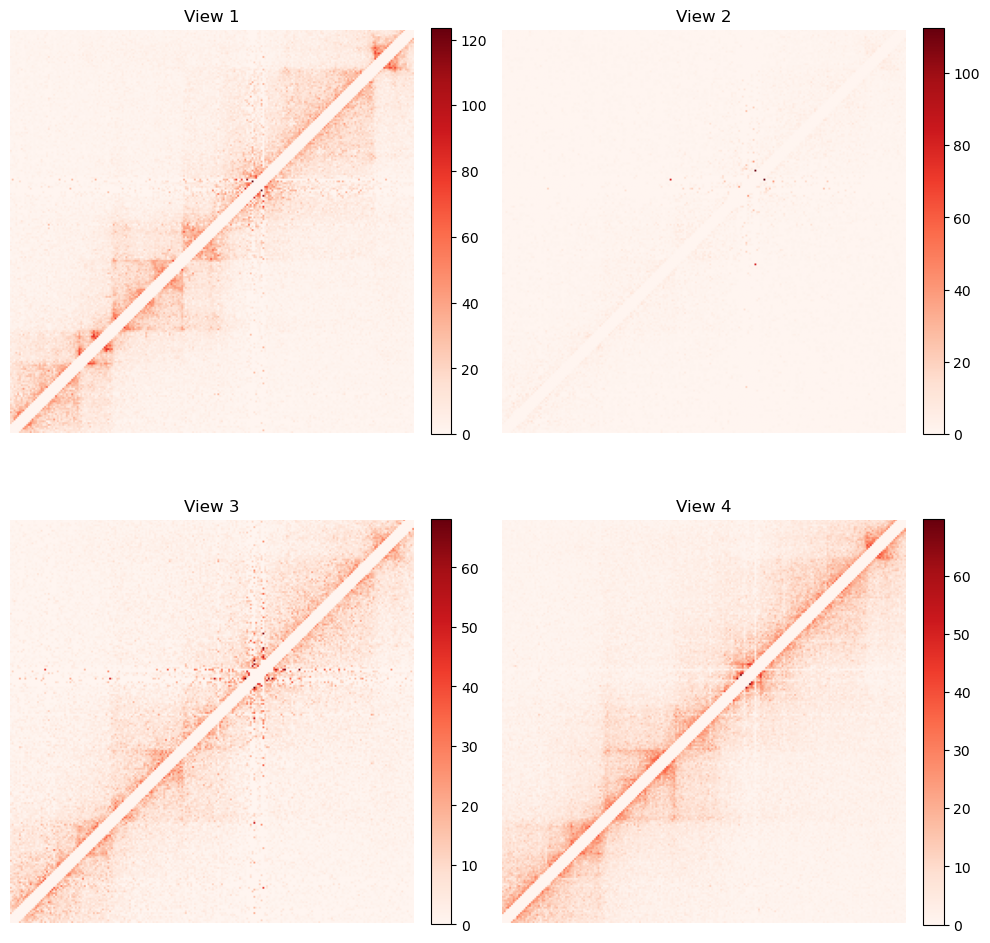

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load your tensor (shape: [4, 1, 224, 224])
tensor = train_dataset.data[100][0]  # shape: [4, 1, 224, 224]
tensor = tensor.squeeze(1)  # remove singleton channel dimension → [4, 224, 224]

# Create diagonal mask to remove ±6 diagonals
num_bins = 224
band_width = 4
mask = np.ones((num_bins, num_bins))
for k in range(-band_width, band_width + 1):
    mask += np.eye(num_bins, k=k) * -1
mask = np.clip(mask, 0, 1)
mask = torch.tensor(mask, dtype=tensor.dtype)

# Apply mask to all 4 slices
masked_tensor = tensor * mask

# Plot in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ['View 1', 'View 2', 'View 3', 'View 4']

for i in range(4):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(masked_tensor[i], cmap='Reds', origin='lower')
    ax.set_title(titles[i])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn as nn


class SINCERELoss(nn.Module):
    def __init__(self, temperature=0.07) -> None:
        super().__init__()
        self.temperature = temperature

    def forward(self, embeds: torch.Tensor, labels: torch.tensor):
        """Supervised InfoNCE REvisited loss with cosine distance

        Args:
            embeds (torch.Tensor): (B, D) embeddings of B images normalized over D dimension.
            labels (torch.tensor): (B,) integer class labels.

        Returns:
            torch.Tensor: Scalar loss.
        """
        # calculate logits (activations) for each embeddings pair (B, B)
        # using matrix multiply instead of cosine distance function for ~10x cost reduction
        logits = embeds @ embeds.T
        logits /= self.temperature
        # determine which logits are between embeds of the same label (B, B)
        same_label = labels.unsqueeze(0) == labels.unsqueeze(1)

        # masking with -inf to get zeros in the summation for the softmax denominator
        denom_activations = torch.full_like(logits, float("-inf"))
        denom_activations[~same_label] = logits[~same_label]
        # get logsumexp of the logits between embeds of different labels for each row (B,)
        base_denom_row = torch.logsumexp(denom_activations, dim=0)
        # reshape to be (B, B) with row values equivalent, to be masked later
        base_denom = base_denom_row.unsqueeze(1).repeat((1, len(base_denom_row)))

        # get mask for numerator terms by removing comparisons between an image and itself (B, B)
        in_numer = same_label
        in_numer[torch.eye(in_numer.shape[0], dtype=bool)] = False
        # delete same_label so don't need to copy for in_numer
        del same_label
        # count numerator terms for averaging (B,)
        numer_count = in_numer.sum(dim=0)
        # numerator activations with others zeroed (B, B)
        numer_logits = torch.zeros_like(logits)
        numer_logits[in_numer] = logits[in_numer]

        # construct denominator term for each numerator via logsumexp over a stack (B, B)
        log_denom = torch.zeros_like(logits)
        log_denom[in_numer] = torch.stack(
            (numer_logits[in_numer], base_denom[in_numer]), dim=0).logsumexp(dim=0)

        # cross entropy loss of each positive pair with the logsumexp of the negative classes (B, B)
        # entries not in numerator set to 0
        ce = -1 * (numer_logits - log_denom)
        # take average over rows with entry count then average over batch
        loss = torch.sum(ce / numer_count) / ce.shape[0]
        return loss


class MultiviewSINCERELoss(SINCERELoss):
    def __init__(self, temperature=0.07) -> None:
        super().__init__(temperature)

    def forward(self, embeds, labels: torch.tensor):
        """Supervised InfoNCE with cosine distance and multiple image views

        Args:
            embeds (torch.Tensor): (B, V, D) embeddings of V augmented views of B images,
                                   normalized over D dimension.
            labels (torch.tensor): (B,) integer class labels.

        Returns:
            torch.Tensor: Scalar loss.
        """
        # collapse view dimension, leaving views next to each other
        reshaped_embeds = torch.reshape(embeds, (-1, embeds.shape[2]))
        # repeat labels to account for views
        labels = labels.repeat_interleave(embeds.shape[1])
        return super().forward(reshaped_embeds, labels)


In [11]:
import torch
batch_loss = 0
test_list =[[[torch.rand(4), torch.rand(4), torch.rand(4), torch.rand(4)],[1,1,0,0]],[[torch.rand(4), torch.rand(4), torch.rand(4), torch.rand(4)],[1,1,0,0]],[[torch.rand(4), torch.rand(4), torch.rand(4), torch.rand(4)],[1,1,0,0]]]
for tile in test_list:
        control=[]
        treatment=[]
        views, labels = tile
        #views = model(views)
        for i, lab in enumerate(labels):
            if lab==0:
                control.append(views[i])
            if lab==1: 
                treatment.append(views[i])
        control_tensor   = torch.stack(control,   dim=0)   # shape [n_control,   f_dim]
        treatment_tensor = torch.stack(treatment, dim=0)   # shape [n_treatment, f_dim]
        tile_loss_info   = torch.stack([control_tensor, treatment_tensor], dim=0)
        print(tile_loss_info)
        loss_fn = MultiviewSINCERELoss()
        condition_labels = torch.tensor([0, 1], dtype=torch.long)
        tile_loss=loss_fn(tile_loss_info, condition_labels)/2
        print(tile_loss)



tensor([[[0.0291, 0.7166, 0.9207, 0.3132],
         [0.8088, 0.1723, 0.4919, 0.3272]],

        [[0.2722, 0.9891, 0.2267, 0.8092],
         [0.7472, 0.8412, 0.5029, 0.3798]]])
tensor(1.7202)
tensor([[[0.2408, 0.1427, 0.7201, 0.1342],
         [0.6623, 0.9678, 0.4040, 0.1525]],

        [[0.4364, 0.8715, 0.8415, 0.3419],
         [0.7057, 0.0957, 0.3701, 0.1776]]])
tensor(3.5491)
tensor([[[0.1001, 0.0501, 0.3603, 0.5806],
         [0.5598, 0.3473, 0.7496, 0.0344]],

        [[0.3969, 0.8613, 0.7181, 0.4736],
         [0.9557, 0.9512, 0.8104, 0.5483]]])
tensor(2.7286)


In [11]:
with open("demofile.txt", "w") as f:
    for x in train_dataset.pos:
        f.write(f"{x}")

In [4]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
train_loader = DataLoader(train_dataset, batch_size=5, sampler=RandomSampler(train_dataset), num_workers=1,  
    pin_memory=True)  


In [5]:
import HiSiNet.models as models
model = eval("models.SLeNet")(mask=True, image_size=224, triplet=True)
x1, x2, x3 = next(iter(train_loader))
feat1, feat2, feat3 = model(x1, x2, x3)


Traceback (most recent call last):
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/shutil.py", line 769, in rmtree
    _rmtree_safe_fd(fd, path, onexc)
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/shutil.py", line 697, in _rmtree_safe_fd
    onexc(os.unlink, fullname, err)
  File "/home/tt920/.conda/envs/hisinet_test/lib/python3.12/shutil.py", line 695, in _rmtree_safe_fd
    os.unlink(entry.name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs0000000b0001b55c00006308'

In [19]:
#data.save('input1.mlhic')
#data1.save('input2.mlhic')
#data2.save('input3.mlhic')
#data3.save('input4.mlhic')

NameError: name 'data3' is not defined

In [2]:
data = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPPaxip1KOR1.mlhic')
data1 = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPPaxip1KOR2.mlhic')
data2 = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPWTR3.mlhic')
data3 = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPWTR4.mlhic')

In [9]:
data.data[0][0][0]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 30.6546, 59.9389, 31.4328],
        [ 0.0000,  0.0000,  0.0000,  ..., 59.9389, 18.9905, 32.0107],
        [ 0.0000,  0.0000,  0.0000,  ..., 31.4328, 32.0107, 30.2164]])

In [7]:
data = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPPaxip1KOR1.mlhic')
#data1 = HiCDatasetDec.load('/home/tt920/mnt/scratch/tt920/mlhic/train_CD69negDPPaxip1KOR2.mlhic')
group=GroupedHiCDataset([data, data1])
twin = SiameseHiCDataset(group)

list of HiCdatasets is not list type
List of HiCDatasets need to be a list containing only HiCDataset objects.


In [13]:

for data in group:
    if not isinstance(data, HiCDataset):
        print("List of HiCDatasets need to be a list containing only HiCDataset objects.")
    print(data.metadata['filename'])





List of HiCDatasets need to be a list containing only HiCDataset objects.


AttributeError: 'tuple' object has no attribute 'metadata'

In [3]:
twin= SiameseHiCDataset([data,data1])



6337

In [19]:
twin.data[0][0].shape

torch.Size([1, 256, 256])

In [8]:
group=GroupedHiCDataset(twin)

list of HiCDataset is not list type


AttributeError: 'tuple' object has no attribute 'resolution'

In [16]:
data_test.stride_length

320000

In [25]:
len(data_test.positions)

7165

In [19]:
!pip install torchvision

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.2 MB/s eta 0:00:00


In [11]:
import hicstraw
import numpy as np
hic = hicstraw.HiCFile("/home/tt920/mnt/network/lymphdev/Tim/GSM4386025_hic_48h_rep2.hic")
#for chrom in hic.getChromosomes():
 #   print(chrom.name, chrom.length)
#print(hic.getGenomeID())
#print(hic.getResolutions())
chrom_sizes = {
            c.name: c.length
            for c in hic.getChromosomes()
            if c.name != "All"
        }
#print(chrom_sizes)
to_load = [ch for ch in chrom_sizes]
#print(to_load)
size = [c.length for c in hic.getChromosomes()]
#print(size)
mzd = hic.getMatrixZoomData('chr1', 'chr1', "observed", "KR", "BP", 10000)
numpy_matrix = mzd.getRecordsAsMatrix(194880000-2240000, 194880000, 194880000-2240000, 194880000)
mat = np.nan_to_num(numpy_matrix)
mat_no_diagonal = mat + mat.T
mat = (mat + mat.T - np.diag(np.diag(mat))) 



MemoryError: std::bad_alloc

In [7]:
print(chrom_sizes)

{'chr1': 197195432, 'chr2': 181748087, 'chr3': 159599783, 'chr4': 155630120, 'chr5': 152537259, 'chr6': 149517037, 'chr7': 152524553, 'chr8': 131738871, 'chr9': 124076172, 'chr10': 129993255, 'chr11': 121843856, 'chr12': 121257530, 'chr13': 120284312, 'chr14': 125194864, 'chr15': 103494974, 'chr16': 98319150, 'chr17': 95272651, 'chr18': 90772031, 'chr19': 61342430, 'chrX': 166650296, 'chrY': 15902555, 'chrM': 16299}


In [49]:
print(mat_no_diagonal)

[[ 69.67932892 127.22177124  64.21498871 ...   0.           0.
    0.        ]
 [127.22177124  76.07404327 106.4254837  ...   0.           0.
    1.55810022]
 [ 64.21498871 106.4254837   60.73197556 ...   0.           0.
    1.47659743]
 ...
 [  0.           0.           0.         ...  75.24132538 154.20509338
   79.73141479]
 [  0.           0.           0.         ... 154.20509338  77.76436615
  125.03676605]
 [  0.           1.55810022   1.47659743 ...  79.73141479 125.03676605
   74.38690948]]


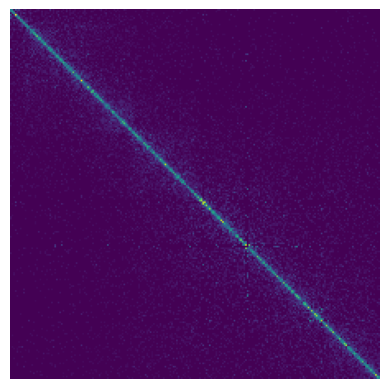

In [9]:
plt.imshow(numpy_matrix)
plt.axis('off')  # Turn off axis labels
plt.show()

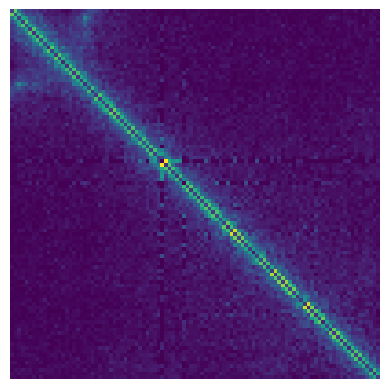

In [11]:
plt.imshow(mat)
plt.axis('off')  # Turn off axis labels
plt.show()

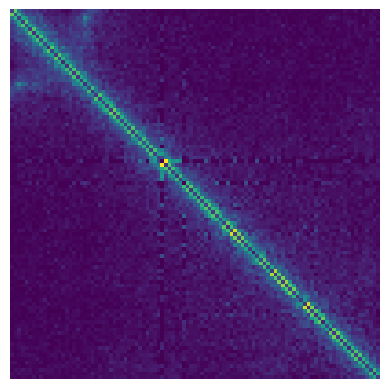

In [10]:
plt.imshow(mat.T)
plt.axis('off')  # Turn off axis labels
plt.show()

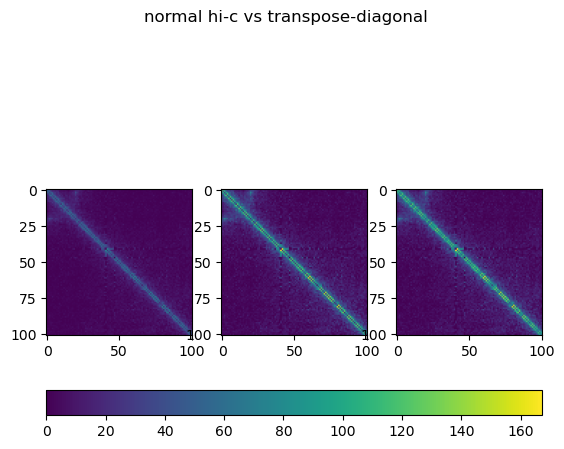

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors

datasets = [
    numpy_matrix, mat, mat_no_diagonal
]

fig, axs = plt.subplots(1,3)
fig.suptitle('normal hi-c vs transpose-diagonal')

# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min(datasets), vmax=np.max(datasets))

images = []
for ax, data in zip(axs.flat, datasets):
    images.append(ax.imshow(data, norm=norm))

fig.colorbar(images[1], ax=axs, orientation='horizontal', fraction=.1)

plt.show()

### Create augmentation functions


In [5]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

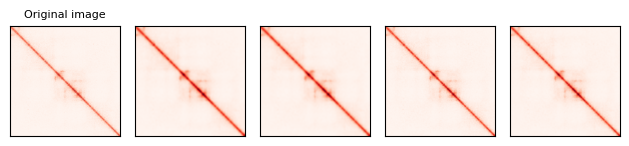

In [ ]:
#Blurring 
blurrer = T.GaussianBlur(kernel_size=(5), sigma=(0.1, 3))
orig_img = Image.fromarray(numpy_matrix)
blurred_imgs = [blurrer(orig_img) for _ in range(4)]
plot(blurred_imgs, cmap="Reds")


In [ ]:
def poisson_resample(matrix, normalize_total=True):
    """
    Poisson-sample each entry of `matrix` as its own mean.
    """
    # Get lower triangle of matrix to enforce symmetry later
    lower_triangle_hic=np.tril(matrix)
    # Draw Poisson samples
    aug = np.random.poisson(lam=lower_triangle_hic).astype(np.float32)
    # Get diagonal of re-sampled Hi-C map
    diagonal=np.diag(np.diag(aug))

    whole_transformed_hic=(aug + aug.T - diagonal)
    
    # 4) (Optional) Normalize back to original total count
    if normalize_total:
        orig_sum = matrix.sum()
        new_sum = whole_transformed_hic.sum()
        if new_sum > 0:
            whole_transformed_hic *= (orig_sum / new_sum)
    return whole_transformed_hic

resampled=poisson_resample(numpy_matrix)


In [33]:
# random dropout
def random_dropout(matrix, dropout_lower_bound, dropout_upper_bound):
    dropout_matrix=matrix.copy()
    dropout = random.uniform(dropout_lower_bound, dropout_upper_bound) 
    num_to_replace = int(np.count_nonzero(matrix) * dropout)
    non_zero_flat_indices = np.flatnonzero(matrix)
    chosen_indices = np.random.choice(non_zero_flat_indices, num_to_replace, replace=False)
    dropout_matrix.flat[chosen_indices]= 0

    return dropout_matrix

dropout=random_dropout(numpy_matrix, 0.05,0.2)

In [57]:
torch.cuda.is_available()

False

In [51]:
import numpy as np
import random
import torch

class Augmentations:
    def __init__(self):
        pass

    def __call__(self, matrix):
        rand = random.randrange(3)
        if rand == 0:
            augmented = matrix
        elif rand == 1:
            augmented = self.poisson_resample(matrix)
        else:
            augmented = self.random_dropout(matrix)

        return augmented

    @staticmethod
    def poisson_resample(matrix, normalize_total=True):
        if torch.is_tensor(matrix):
            lower_triangle = torch.tril(matrix)
            aug = torch.poisson(lower_triangle)
            diag = torch.diag(torch.diag(aug))
            transformed = aug + aug.T - diag

            if normalize_total:
                orig_sum = matrix.sum()
                new_sum = transformed.sum()
                if new_sum > 0:
                    transformed *= (orig_sum / new_sum)

        else:
            lower_triangle = np.tril(matrix)
            aug = np.random.poisson(lam=lower_triangle).astype(np.float32)
            diag = np.diag(np.diag(aug))
            transformed = aug + aug.T - diag

            if normalize_total:
                orig_sum = matrix.sum()
                new_sum = transformed.sum()
                if new_sum > 0:
                    transformed *= (orig_sum / new_sum)

        return transformed

    @staticmethod
    def random_dropout(matrix, dropout_lower_bound=0.025, dropout_upper_bound=0.075):
        dropout = random.uniform(dropout_lower_bound, dropout_upper_bound)

        if torch.is_tensor(matrix):
            matrix = matrix.clone()
            non_zero = torch.nonzero(matrix, as_tuple=False)
            n = int(dropout * non_zero.size(0))
            if n > 0:
                chosen = non_zero[torch.randperm(non_zero.size(0))[:n]]
                matrix[chosen[:, 0], chosen[:, 1]] = 0
        else:
            matrix = matrix.copy()
            non_zero = np.flatnonzero(matrix)
            n = int(dropout * len(non_zero))
            if n > 0:
                chosen = np.random.choice(non_zero, n, replace=False)
                matrix.flat[chosen] = 0

        return matrix
    
    @staticmethod
    def normalize(matrix):
        """Normalize tensor or numpy array to [0, 1] by dividing by max."""
        if torch.is_tensor(matrix):
            max_val = torch.max(matrix)
            return matrix / max_val if max_val > 0 else matrix
        else:
            max_val = np.max(matrix)
            return matrix / max_val if max_val > 0 else matrix


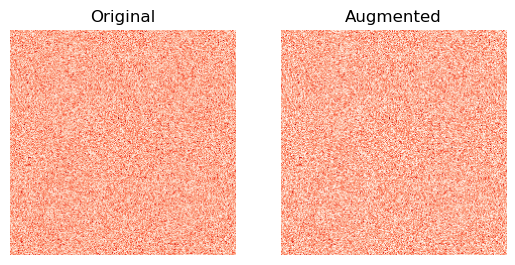

In [52]:
import torch

mat = torch.poisson(torch.ones(224, 224) * 5)
aug = Augmentations()

augmented = aug(mat)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mat.numpy(), cmap='Reds')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(augmented.numpy(), cmap='Reds')
ax2.set_title('Augmented')
ax2.axis('off')
plt.show()

In [61]:
test = torch.poisson(torch.ones(224, 224) * 5)
print(test.shape)
test = test.view(1,1,224,224)
print(test.shape)

torch.Size([224, 224])
torch.Size([1, 1, 224, 224])


In [5]:
import torch
import random
def random_dropout(matrix, dropout_lower_bound=0.025, dropout_upper_bound=0.075):
    
    dropout = random.uniform(dropout_lower_bound, dropout_upper_bound)

    if torch.is_tensor(matrix):
        matrix = matrix.squeeze(0)
        matrix = matrix.clone()
        non_zero = torch.nonzero(matrix, as_tuple=False)
        n = int(dropout * non_zero.size(0))
        if n > 0:
            chosen = non_zero[torch.randperm(non_zero.size(0))[:n]]
            matrix[chosen[:, 0], chosen[:, 1]] = 0

    return matrix.unsqueeze(0)

test = torch.poisson(torch.ones(224, 224) * 5).unsqueeze(0)

random_dropout(test).shape

torch.Size([1, 224, 224])

In [8]:
max_vals = test.amax(dim=(1,2,3), keepdim=True)

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

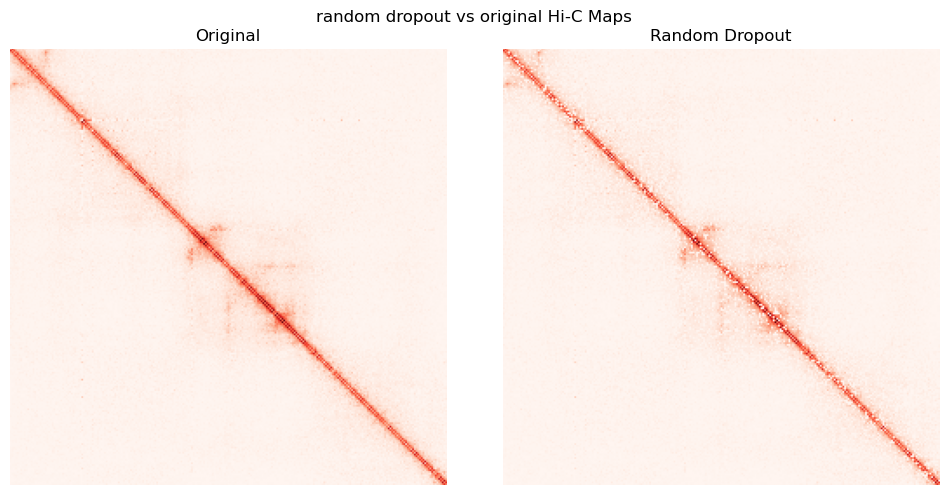

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('random dropout vs original Hi-C Maps')

# Plot the original Hi-C map
ax1.imshow(numpy_matrix, cmap='Reds')
ax1.set_title('Original')
ax1.axis('off')

# Plot the resampled Hi-C map
ax2.imshow(dropout, cmap='Reds')
ax2.set_title('Random Dropout')
ax2.axis('off')


plt.tight_layout()
plt.show()

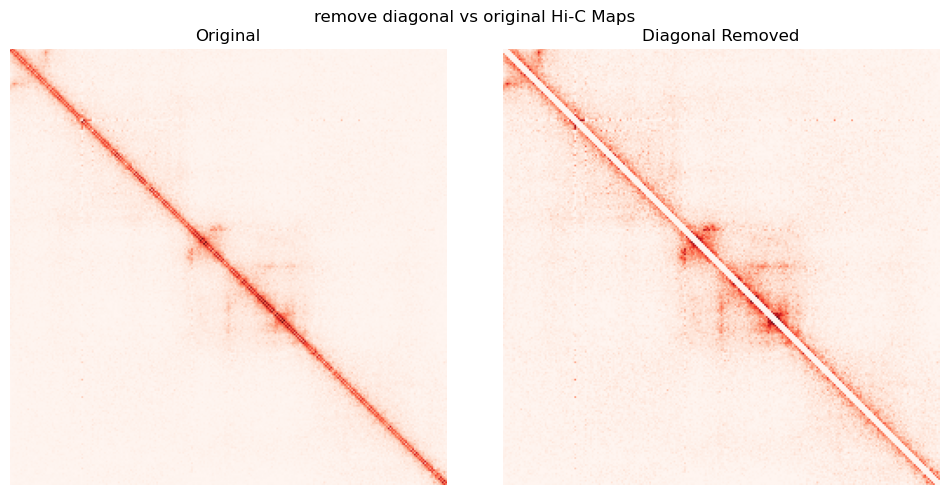

In [36]:
mask = np.tril(numpy_matrix, k=-3)+np.triu(numpy_matrix, k=3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('remove diagonal vs original Hi-C Maps')

# Plot the original Hi-C map
ax1.imshow(numpy_matrix, cmap='Reds')
ax1.set_title('Original')
ax1.axis('off')

# Plot the resampled Hi-C map
ax2.imshow(mask, cmap='Reds')
ax2.set_title('Diagonal Removed')
ax2.axis('off')


plt.tight_layout()
plt.show()

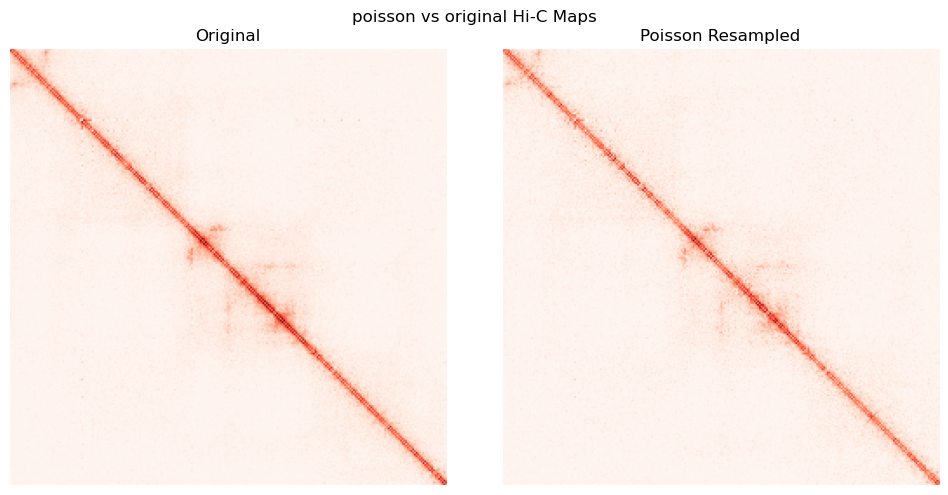

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('poisson vs original Hi-C Maps')

# Plot the original Hi-C map
ax1.imshow(numpy_matrix, cmap='Reds')
ax1.set_title('Original')
ax1.axis('off')

# Plot the resampled Hi-C map
ax2.imshow(resampled, cmap='Reds')
ax2.set_title('Poisson Resampled')
ax2.axis('off')


plt.tight_layout()
plt.show()


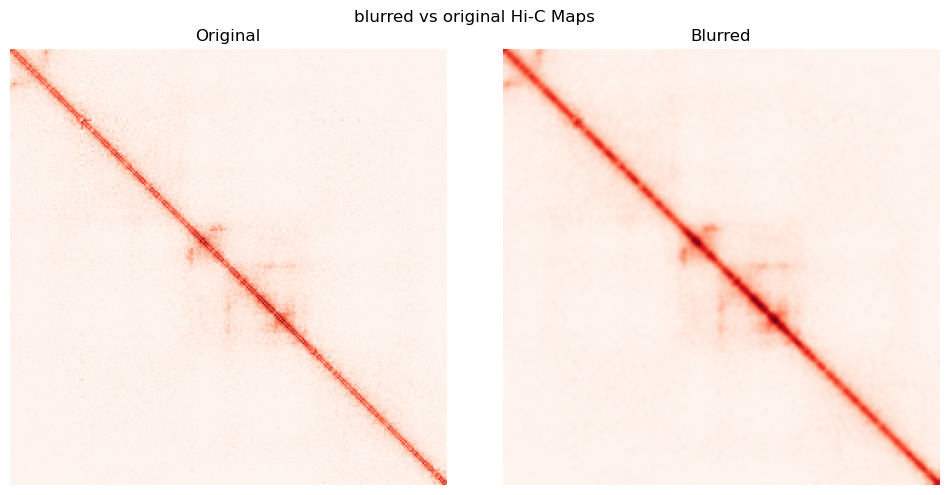

In [25]:
blurrer = T.GaussianBlur(kernel_size=(3), sigma=(0.5, 2))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('blurred vs original Hi-C Maps')

# Plot the original Hi-C map
ax1.imshow(numpy_matrix, cmap='Reds')
ax1.set_title('Original')
ax1.axis('off')

# Plot the resampled Hi-C map
ax2.imshow(np.asarray(blurrer(Image.fromarray(numpy_matrix))), cmap='Reds')
ax2.set_title('Blurred')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Random dropout